In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from lyric_model import CNNModel
from vocab import Vocabulary, build_vocab
from lyrics_dataset import LyricsDataset, build_lyrics_df
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from lstm_model import LSTMModel
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhangmingyin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangmingyin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhangmingyin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'Artist': 'TheSylvers', 'Title': 'BoogieFever', 'Mood': [0, 0, 1, 0], 'Lyrics': 'contributorsboogi fever lyricsboogi fever got boogi boogi fever think go around took babi show turn speaker turn radio watch silent movi dig funki sound got boogi fever like boogi uh huh got boogi fever think go around took babi pizza parlor pizza parlor get bite eat ah ah ah put money jukebox know ate pizza danc beat got boogi fever like boogi uh huh got boogi fever think go around night long bump bump bump ye ye ye yeah yeah kept go strong bump bump bump bump bump bump yeah yeah might also likei call doctor telephon doctor doctor said doctor doctor pleas got feel rock tell new diseas call boogi fever got boogi uh huh get boogi fever think go around fever fever fever oooh oooh oooh oooh oooh oooh oooh oooh oooh night long bump bump bump ye ye ye yeah kept go strong bump bump bump yeah everybodi got boogi fever boogi fever babi boogi get get boogi fever fever babi think go around around around said got bo

In [6]:

root_dir = '/Users/zhangmingyin/Desktop/lyric/ml_lyrics'
data = build_lyrics_df(root_dir)

vocab = Vocabulary()
vocab = build_vocab(data, vocab)

# Determine the maximum length of lyrics in the dataset
# max_length = max(len(sample['Lyrics'].split()) for sample in data)# +1 for the <end> token


dataset = LyricsDataset(data, vocab, 0)

In [9]:
embedding_dim = 100  # Example dimension, adjust as per your GloVe file
# Initialize an embedding matrix with random values
embedding_matrix = np.random.rand(len(vocab), embedding_dim)

glove_path = '/Users/zhangmingyin/Desktop/lyric/glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Populate embedding matrix with GloVe embeddings
for word, idx in vocab.word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

# Convert embedding matrix to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [10]:
def lyrics_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (lyric, mood).
    Args:
        data: list of tuple (lyric, mood). 
            - lyric: torch tensor of variable length.
            - mood: torch tensor of shape (4,).
    Returns:
        lyrics: torch tensor of shape (batch_size, padded_length).
        moods: torch tensor of shape (batch_size, 4).
        lengths: list; valid length for each padded lyric.
    """
    data.sort(key=lambda x: len(x[0]), reverse=True)
    lyrics, moods = zip(*data)

    lengths = [len(lyric) for lyric in lyrics]

    padded_lyrics = pad_sequence(lyrics, batch_first=True, padding_value=0)

    moods = torch.stack(moods, 0)

    return padded_lyrics, moods, lengths


In [7]:
train_ratio = 0.8
test_ratio = 1 - train_ratio

total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=lyrics_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=lyrics_collate_fn)

print( len(train_dataset))
print( len(test_dataset))

训练集大小: 1557
测试集大小: 390


In [11]:
vocab_size = len(vocab)
embedding_dim = 100  # This should match the dimension of the GloVe embeddings
hidden_dim = 300
output_dim = 4
n_layers = 2
bidirectional = True
dropout_rate = 0.5
pad_index = vocab.word2idx['<pad>']

# Initialize model
model = LSTMModel(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
    embedding_matrix
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)



In [16]:
from sklearn.metrics import accuracy_score



train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
train_losses = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []
test_losses = []

num_epochs = 30

def train_model(model, train_loader, test_loader, criterion, optimizer,scheduler, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        for i, (lyrics, mood, lengths) in enumerate(train_loader):
            optimizer.zero_grad()
            lyrics, mood = lyrics.to(model.device), mood.to(model.device)
            outputs = model(lyrics,lengths)
            loss = criterion(outputs, mood)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            preds = F.one_hot(preds, num_classes=4)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(mood.cpu().numpy())
        
        # Calculate training accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        train_accuracies.append(accuracy)
        train_precisions.append(precision)
        train_recalls.append(recall)
        train_f1s.append(f1)
        train_losses.append(total_loss / len(train_loader))
        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy * 100:.2f}%,Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1 Score: {f1 * 100:.2f}%')
        
        test_accuracy, test_precision, test_recall, test_f1,test_loss = evaluate_model(model, test_loader, criterion)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)
        test_losses.append(test_loss)
        
        

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for lyrics, mood, lengths  in test_loader:
            lyrics, mood = lyrics.to(model.device), mood.to(model.device)
            outputs = model(lyrics, lengths )
            loss = criterion(outputs, mood)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            preds = F.one_hot(preds, num_classes=4)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(mood.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    average_loss = total_loss / len(test_loader)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%,Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1 Score: {f1 * 100:.2f}%')
    return accuracy, precision, recall, f1, average_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.device = device  

train_model(model, train_loader, test_loader, criterion, optimizer,scheduler, num_epochs)


Epoch 1/30, Loss: 1.178824854140379, Accuracy: 44.32%,Precision: 43.39%, Recall: 44.00%, F1 Score: 42.08%
Test Loss: 1.0270, Test Accuracy: 58.46%,Precision: 61.39%, Recall: 58.90%, F1 Score: 59.79%
Epoch 2/30, Loss: 1.0166954471140492, Accuracy: 56.58%,Precision: 58.72%, Recall: 56.28%, F1 Score: 55.72%


/Users/zhangmingyin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1.0153, Test Accuracy: 52.31%,Precision: 40.45%, Recall: 52.23%, F1 Score: 45.35%
Epoch 3/30, Loss: 0.970112103588727, Accuracy: 58.77%,Precision: 58.51%, Recall: 58.57%, F1 Score: 58.25%
Test Loss: 1.0143, Test Accuracy: 56.67%,Precision: 62.81%, Recall: 57.92%, F1 Score: 55.50%
Epoch 4/30, Loss: 0.9413992142190739, Accuracy: 62.36%,Precision: 63.22%, Recall: 62.22%, F1 Score: 61.92%
Test Loss: 0.9629, Test Accuracy: 58.72%,Precision: 69.52%, Recall: 58.35%, F1 Score: 58.92%
Epoch 5/30, Loss: 0.7733589416863967, Accuracy: 69.69%,Precision: 69.71%, Recall: 69.52%, F1 Score: 69.56%
Test Loss: 0.8191, Test Accuracy: 64.62%,Precision: 69.29%, Recall: 64.86%, F1 Score: 64.72%
Epoch 6/30, Loss: 0.7551308408075449, Accuracy: 68.53%,Precision: 68.35%, Recall: 68.37%, F1 Score: 68.16%
Test Loss: 0.8674, Test Accuracy: 64.36%,Precision: 66.36%, Recall: 64.38%, F1 Score: 63.77%
Epoch 7/30, Loss: 0.6399138661063447, Accuracy: 75.98%,Precision: 76.04%, Recall: 75.94%, F1 Score: 75.97%
T

In [18]:
import torch


model_path = '/Users/zhangmingyin/Desktop/lyric/data_model/model_lstm.pt'
data_path = '/Users/zhangmingyin/Desktop/lyric/data_model/training_lstm.pt'

torch.save(model.state_dict(), model_path)

training_data = {
    'train_accuracies': train_accuracies,
    'train_precisions': train_precisions,
    'train_recalls': train_recalls,
    'train_f1s': train_f1s,
    'train_losses': train_losses,
    'test_accuracies': test_accuracies,
    'test_precisions': test_precisions,
    'test_recalls': test_recalls,
    'test_f1s': test_f1s,
    'test_losses': test_losses
}

torch.save(training_data, data_path)


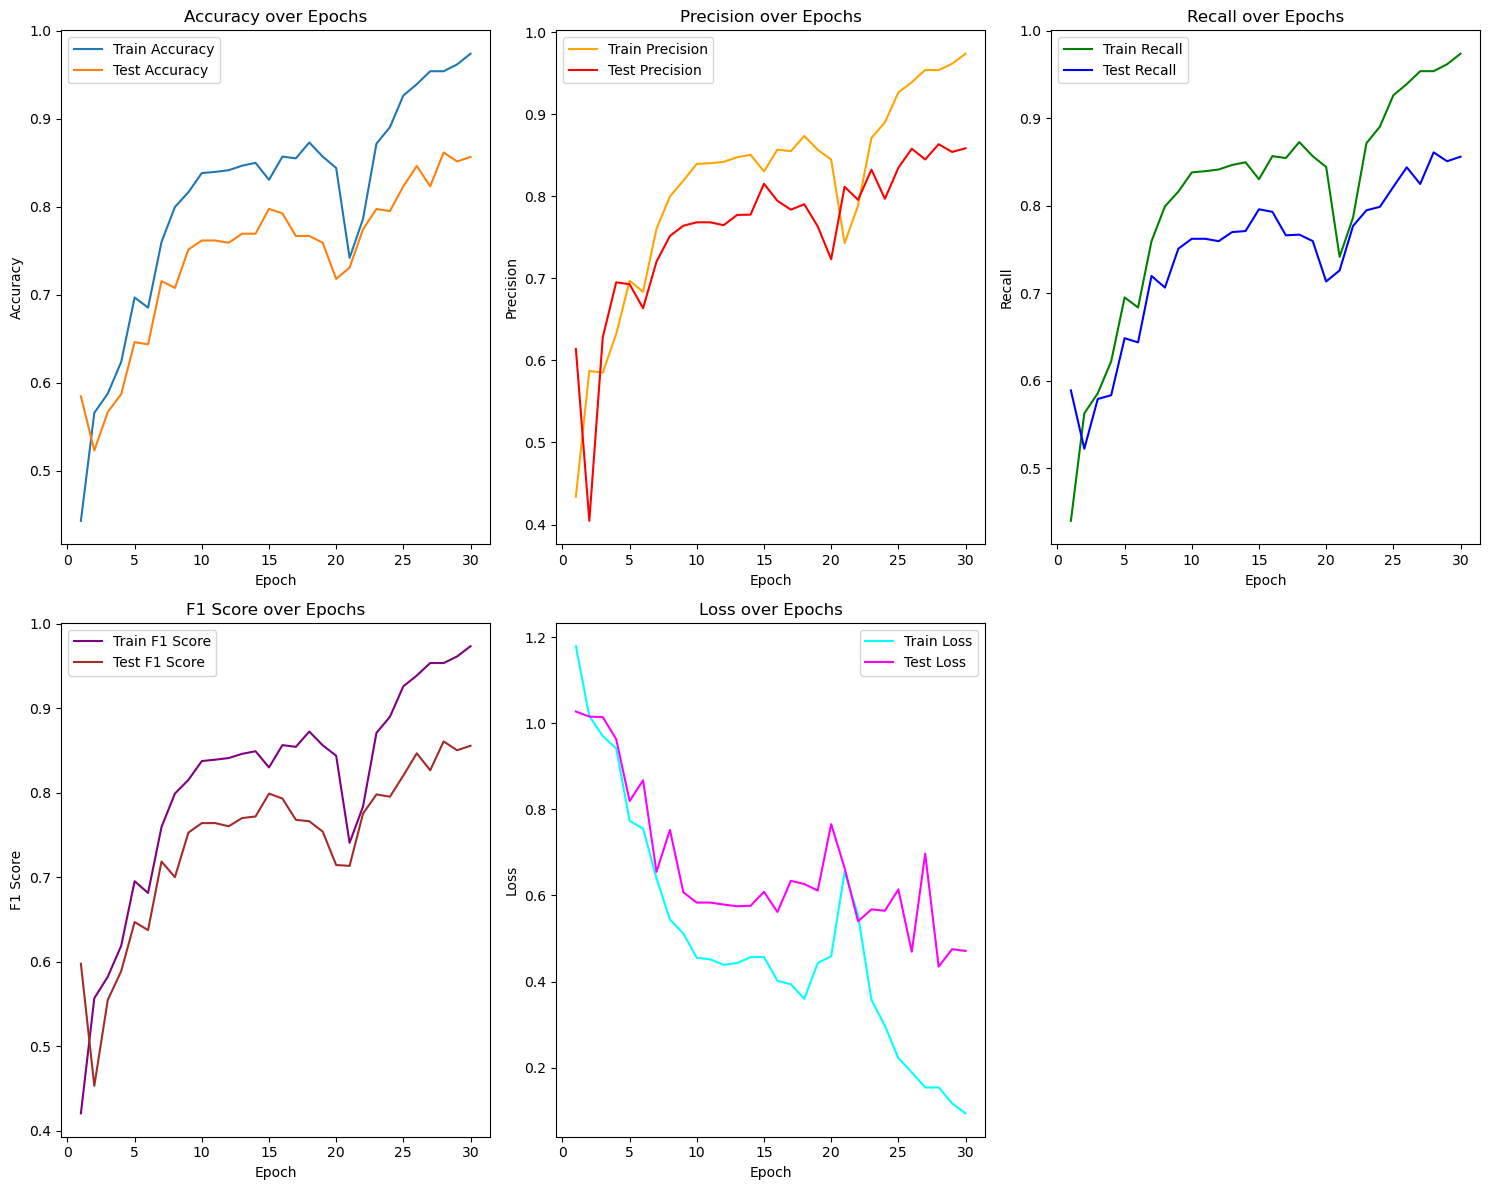

In [1]:
import torch
import matplotlib.pyplot as plt

training_data = torch.load('/Users/zhangmingyin/Desktop/lyric/data_model/training_lstm.pt')

num_epochs = len(training_data['train_accuracies'])
epochs = range(1, num_epochs + 1)

train_accuracies = training_data['train_accuracies']
train_precisions = training_data['train_precisions']
train_recalls = training_data['train_recalls']
train_f1s = training_data['train_f1s']
train_losses = training_data['train_losses']

test_accuracies = training_data['test_accuracies']
test_precisions = training_data['test_precisions']
test_recalls = training_data['test_recalls']
test_f1s = training_data['test_f1s']
test_losses = training_data['test_losses']

plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_precisions, label='Train Precision', color='orange')
plt.plot(epochs, test_precisions, label='Test Precision', color='red')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_recalls, label='Train Recall', color='green')
plt.plot(epochs, test_recalls, label='Test Recall', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_f1s, label='Train F1 Score', color='purple')
plt.plot(epochs, test_f1s, label='Test F1 Score', color='brown')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_losses, label='Train Loss', color='cyan')
plt.plot(epochs, test_losses, label='Test Loss', color='magenta')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
model.load_state_dict(torch.load('/Users/zhangmingyin/Desktop/lyric/data_model/model_lstm.pt'))
model.eval()

def generate_predictions(loader, model):
    y_true = []
    y_proba = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for data, moods, lengths in loader:
            padded_lyrics = data
            lengths = lengths
            outputs = model(padded_lyrics, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(moods.numpy())
            y_proba.extend(probabilities.numpy())
            y_pred.extend(predicted.numpy())

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    y_pred = np.array(y_pred)
    
    return y_true, y_proba, y_pred


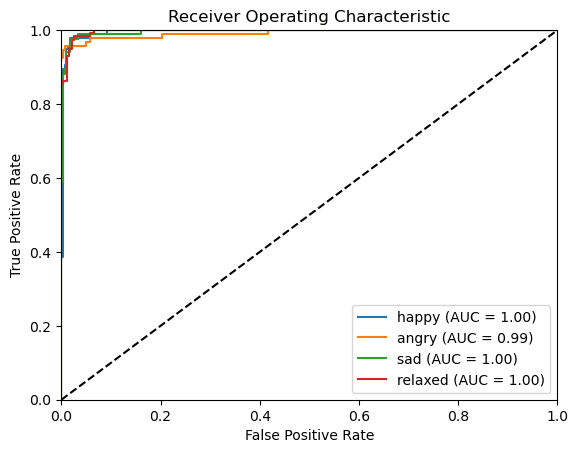

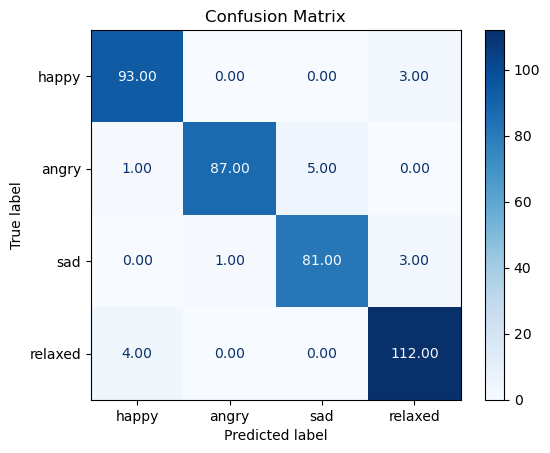

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

classes = ["happy", "angry", "sad", "relaxed"]

def plot_roc_curve(y_true, y_proba, classes):
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title('Confusion Matrix')
    plt.show()

y_true, y_proba, y_pred = generate_predictions(test_loader, model)

plot_roc_curve(y_true, y_proba, classes)
plot_confusion_matrix(y_true, y_pred, classes)
